<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Portfolio_Rebalancing_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.decomposition as sk_decomp
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
ticker_list = ['HDFCBANK', 'NIFTYBEES', 'JUNIORBEES', 'GOLDBEES']
ticker_weights = [1, 3, 3, 3]

In [3]:
price_dict = {}

for ticker_name in ticker_list:
    ticker = yf.Ticker(ticker_name+".NS")

    history_df = ticker.history(period = "1y", interval = '1d')

    price_dict[ticker_name] = history_df['Close']

close_price_df = pd.DataFrame(price_dict)

In [4]:
calc_df = (
    close_price_df.join(close_price_df.shift(1), rsuffix = '_prev')
                  .dropna()
)


for ticker_name in ticker_list:
    calc_df.eval(f'r_{ticker_name} = log({ticker_name}) - log({ticker_name}_prev)', inplace = True)

rate_df = calc_df[[f'r_{ticker_name}' for ticker_name in ticker_list]]
rate_df.columns = ticker_list

<Axes: >

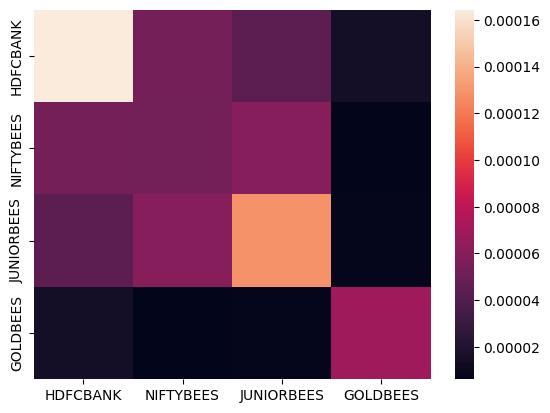

In [5]:
sns.heatmap(rate_df.cov())

In [6]:
pca = sk_decomp.PCA(n_components = 0.99, whiten = True)
transform_data_df = pd.DataFrame(pca.fit_transform(rate_df))
transform_data_df.columns = [f'PC_{idx + 1}' for idx, _ in enumerate(transform_data_df.columns)]

In [7]:
tr_plot_df = transform_data_df.eval('n = 1')
tr_plot_df['n'] = np.cumsum(tr_plot_df['n'])

<Axes: >

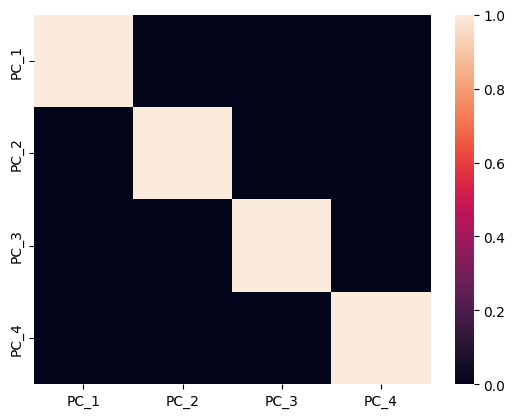

In [8]:
sns.heatmap(transform_data_df.cov())

In [9]:
N = len(transform_data_df.columns)

In [10]:
predicted_rate_df = pd.DataFrame(
    data = pca.inverse_transform(np.random.standard_normal((300, N))),
    columns = rate_df.columns
)

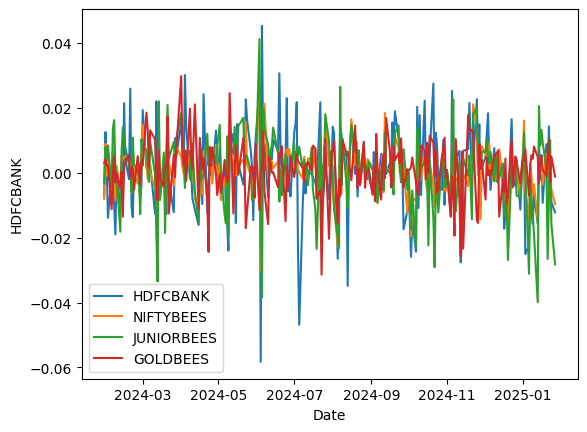

In [11]:
for ticker_name in ticker_list:
    sns.lineplot(x = 'Date', y = f'{ticker_name}', data = rate_df.reset_index(), label = ticker_name)

In [12]:
browinan_motion_df = pd.DataFrame(
    data = 100 * np.exp(np.cumsum(pca.inverse_transform(np.random.standard_normal((len(rate_df), N))), axis = 0)),
    columns = rate_df.columns
)

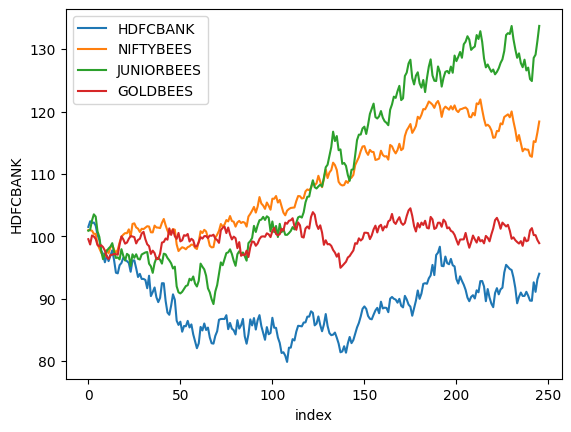

In [13]:
for ticker_name in ticker_list:
    sns.lineplot(x = 'index', y = f'{ticker_name}', data = browinan_motion_df.reset_index(), label = ticker_name)

In [14]:
unit_weightage = {ticker_name : w for ticker_name, w in zip(ticker_list, ticker_weights)}

norm_factor = sum([value for keys, value in unit_weightage.items()])

norm_weightage = {key: value/norm_factor for key, value in unit_weightage.items()}

prev_units = norm_weightage
N = len(ticker_list)

weightage = []

rebal_arr = []
for idx, row_data in browinan_motion_df.iterrows():
    total_value = 0
    for ticker_name in ticker_list:
        total_value += prev_units[ticker_name] * row_data[ticker_name]

    next_units = {ticker_name : (total_value * norm_weightage[ticker_name]) / (row_data[ticker_name]) for ticker_name in ticker_list}
    rebal_arr += [[next_units[ticker_name] for ticker_name in ticker_list] + [total_value]]
    prev_units = next_units

rebalanced_df = pd.DataFrame(rebal_arr, columns = ticker_list + ['Value'])

<Axes: xlabel='index', ylabel='HDFCBANK'>

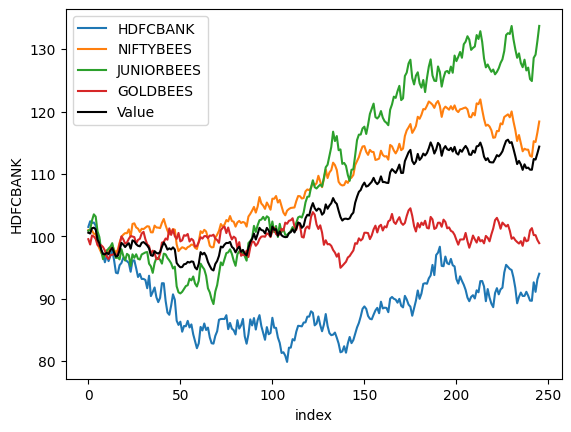

In [15]:
for ticker_name in ticker_list:
    sns.lineplot(x = 'index', y = f'{ticker_name}', data = browinan_motion_df.reset_index(), label = ticker_name)

sns.lineplot(x = 'index', y = 'Value', data = rebalanced_df.reset_index(), label = 'Value', color = 'black')